# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


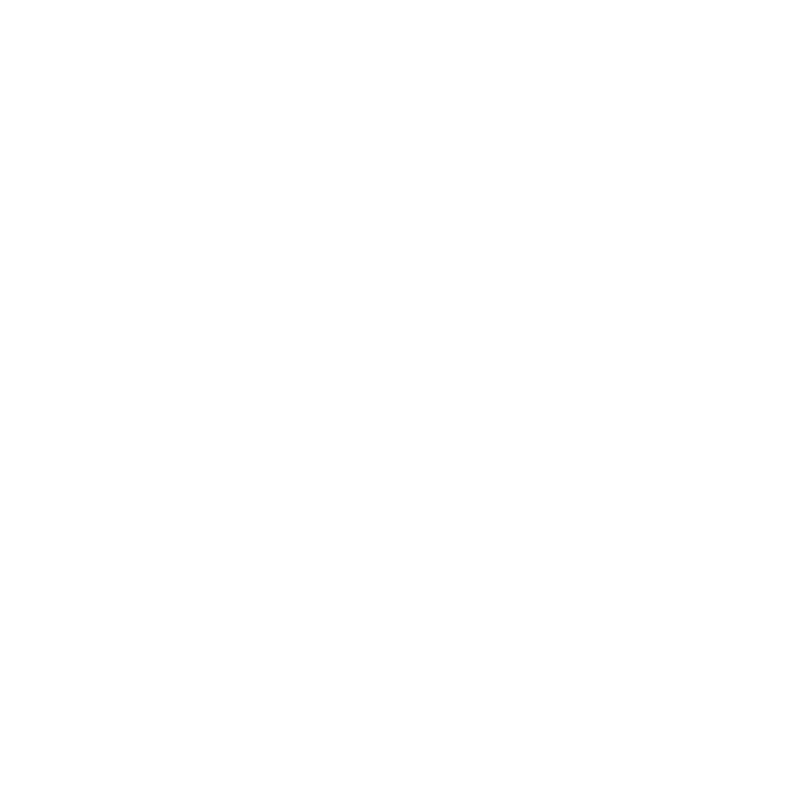

In [174]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
from cycler import cycler
from datetime import datetime
import mplleaflet
import pandas as pd
import numpy as np


def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [175]:
%matplotlib notebook
weather_data = pd.read_csv("data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null object
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


# Data Wrangling

In [176]:
#Selecting the weather station in "MI JACKSON REYNOLDS FLD" and sorting it by Date.
weather_data = weather_data[weather_data["ID"] == "USW00014833"].sort_values(by="Date")

#Converting it to celcius
weather_data["Data_Value"] = weather_data["Data_Value"] / 10 

In [177]:
#Converting to datetime and removing leap days
weather_data["Date"] = pd.to_datetime(weather_data["Date"])
weather_data = weather_data[~((weather_data["Date"].dt.month == 2) & (weather_data["Date"].dt.day == 29))]

#Extracting month and day from the Date column and setting the Date
weather_data["Period"] = weather_data["Date"].dt.strftime("%b-%-d")
weather_data.set_index("Date", inplace=True)

In [178]:
#Creating df for pre 2015 and one for 2015
weather_pre_2015 = weather_data.copy().loc["2005-01-01":"2014-12-31"]
weather_2015 = weather_data.copy().loc["2015-01-01":]

In [179]:
#Creating a new column for Max/Min temperature - grouping by period to get each day's max/min 
weather_pre_2015["Temp_Max"] = weather_pre_2015.groupby("Period")["Data_Value"].transform(max)
weather_pre_2015["Temp_Min"] = weather_pre_2015.groupby("Period")["Data_Value"].transform(min)

weather_2015["Temp_Max"] = weather_2015.groupby("Period")["Data_Value"].transform(max)
weather_2015["Temp_Min"] = weather_2015.groupby("Period")["Data_Value"].transform(min)

In [180]:
#Since I have columns for each row displaying the Max/Min temperature of that day I drop the duplicate Period rows.
weather_2015 = (weather_2015
                .drop_duplicates("Period")
                .reset_index()
                )

weather_pre_2015 = (weather_pre_2015
                    .drop_duplicates("Period")
                    .reset_index()
                    )

In [181]:
#Filtering out the days where 2015 temperatures was higher/lower than 2005-2014.
highest_temps = (weather_2015.where(weather_2015["Temp_Max"] > weather_pre_2015["Temp_Max"])
                 .dropna(axis=0)[["Period", "Temp_Max"]]
                 )

lowest_temps = (weather_2015.where(weather_2015["Temp_Min"] < weather_pre_2015["Temp_Min"])
                 .dropna(axis=0)[["Period", "Temp_Min"]]
                 )

# Configuring the Figure

<IPython.core.display.Javascript object>


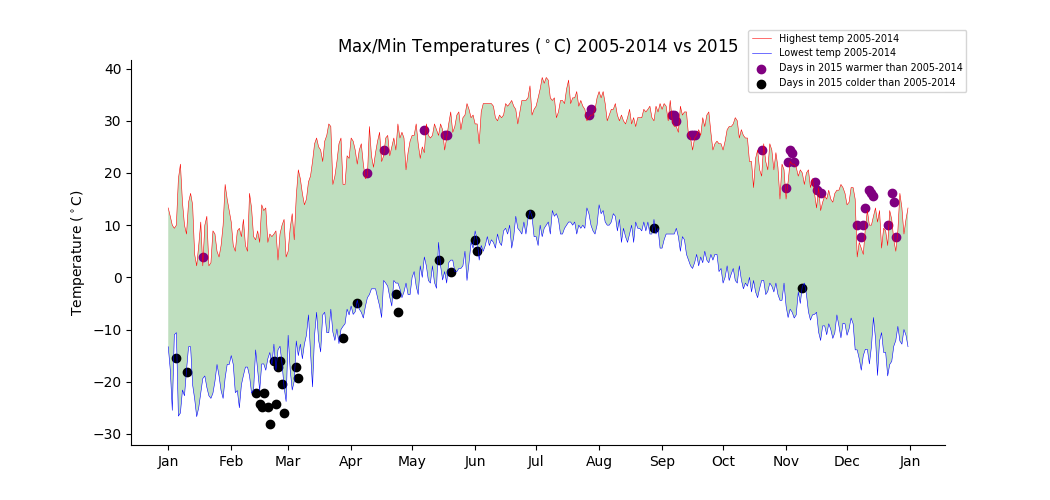

In [189]:
#Setting up the x-axis as date format
ax = plt.gca()
month_day = dates.DateFormatter("%b")
ax.xaxis.set_major_formatter(month_day)
ax.xaxis.set_major_locator(dates.MonthLocator())

#Drawing a line plot for the highest temperatures 2005-2014
for day, temp in [(weather_pre_2015.Period, weather_pre_2015.Temp_Max)]:
    day_x_axis = dates.date2num([datetime.strptime(d, "%b-%d") for d in day])
    plt.plot(day_x_axis, temp, linewidth=0.4, color="r", label="Highest temp 2005-2014")
    
#Drawing a line plot for the lowest temperatures 2005-2014
for day, temp in [(weather_pre_2015.Period, weather_pre_2015.Temp_Min)]:
    day_x_axis = dates.date2num([datetime.strptime(d, "%b-%d") for d in day])
    plt.plot(day_x_axis, temp, linewidth=0.4, color="b", label="Lowest temp 2005-2014")

#Filling the area between max and min temperatures of 2005-2014
fill = ax.fill_between(day_x_axis,
               weather_pre_2015.Temp_Min, weather_pre_2015.Temp_Max, facecolor="green", alpha=0.25)


#Drawing a scatter plot of the days when 2015 was warmer than 2005-2014
for day, temp in [(highest_temps.Period, highest_temps.Temp_Max)]:
    day_x_axis = dates.date2num([datetime.strptime(d, "%b-%d") for d in day])
    plt.scatter(day_x_axis, temp, color="purple", label="Days in 2015 warmer than 2005-2014")

    
#Drawing a scatter plot of the days when 2015 was colder than 2005-2014
for day, temp in [(lowest_temps.Period, lowest_temps.Temp_Min)]:
    day_x_axis = dates.date2num([datetime.strptime(d, "%b-%d") for d in day])
    plt.scatter(day_x_axis, temp, color="black", label="Days in 2015 colder than 2005-2014")

    
#Changing the fig size.
fig = plt.gcf()
fig.set_size_inches(10.5,5)


In [190]:
#Manipulating the axes and removing chart junk.
ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_title("Max/Min Temperatures ($^\circ$C) 2005-2014 vs 2015")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(bbox_to_anchor=(0.925, 0.95),
         bbox_transform=fig.transFigure,
         fontsize="x-small")

plt.savefig("Temperatures 2005-2014 vs 2015")